In [1]:
# imports
import numpy as np
from numpy import loadtxt as loadtxt

import matplotlib.pyplot as plt

import torch
from tqdm import tqdm

from haloidp_analysis import minimize, profile_likelihood, plot_eta, convert_params_to_fit_to_halo_id

from haloidp_analysis import minimize_with_mass

TODO 

- ensembling

In [2]:
# set device

device = "cuda"
type_torch = torch.double

In [3]:
# load in data

materials = ["Si", "Ge"]

observed_rates = []
for material in materials:

    fpath = f'./halo_independent/mock_data/ModelAnsh10MeV_{material}.csv'
    fake_data = loadtxt(fpath,delimiter=',') # shape: (10,2)
    rates = fake_data[:,1]
    observed_rates.append(torch.from_numpy(rates).to(device))



## What are we trying to learn?


`learnable_weights`: the object that PyTorch optimizes

### 1. A set of numbers $g_i$ that parameterize the halo velocity profile

This is usually referred to in the code as `halo_id_params`. Number of elements: `num_steps`.

We want to enforce that the steps are monotonically decreasing. So it might be easier to parameterize the *differences* between steps, and then enforce that all of these differences are stricly negative.

`halo_id_params = -np.cumsum(learnable_weights**2)` will be monotonically decreasing, no matter what `learnable_weights` is.


### 2. The best-fit mass of the DM particle

This will be a scalar. Actually, the true mass is going to be the last element squared, to enforce positivity.

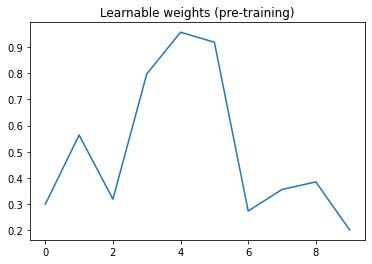

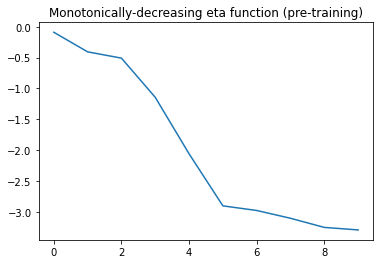

In [10]:
num_steps = 10

# TODO make a clever initialization function

# randomly initialize the values for g_i
learnable_weights = torch.rand(num_steps,dtype=type_torch,device=device)

plt.figure()
plt.plot(learnable_weights.cpu())
plt.title("Learnable weights (pre-training)")
plt.show()

plt.figure()
plt.plot(convert_params_to_fit_to_halo_id(learnable_weights).cpu())
plt.title("Monotonically-decreasing eta function (pre-training)")
plt.show()

# pick a value for the mass
learnable_mass = torch.tensor(np.sqrt(12),dtype=type_torch,device=device)



In [11]:
for FDMn in [0]:

    params_, losses_, masses_ =  minimize_with_mass(FDMn, observed_rates, materials, profile_likelihood, learnable_weights, learnable_mass, epochs=1500,
                                                 lr=0.1, device=device, optimizer_algorithm='Adam', adaptive=True, alpha = 0.01)


100%|██████████| 1500/1500 [00:50<00:00, 29.62it/s]


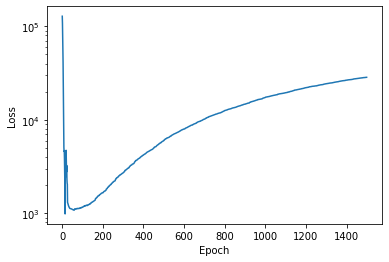

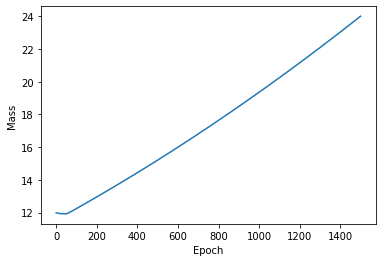

In [12]:
plt.figure()
plt.plot(losses_)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()


plt.figure()
plt.plot(masses_)
plt.xlabel("Epoch")
plt.ylabel("Mass")
plt.show()





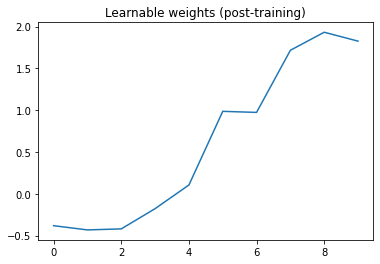

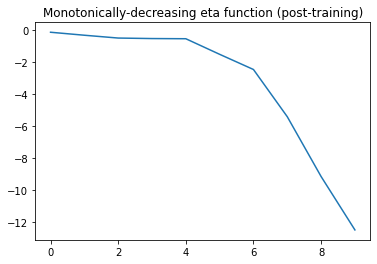

In [13]:
tien_halo_params = [220.0,232,544,0.4e9]


best_fit_params = params_



plt.figure()
plt.plot(best_fit_params.cpu().detach().numpy())
plt.title("Learnable weights (post-training)")
plt.show()

plt.figure()
plt.plot(convert_params_to_fit_to_halo_id(best_fit_params).cpu().detach().numpy())
plt.title("Monotonically-decreasing eta function (post-training)")
plt.show()



(array([2.06934647e-15, 2.06934647e-15, 2.06934647e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.48200114e-15, 1.48000177e-15, 1.47799682e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

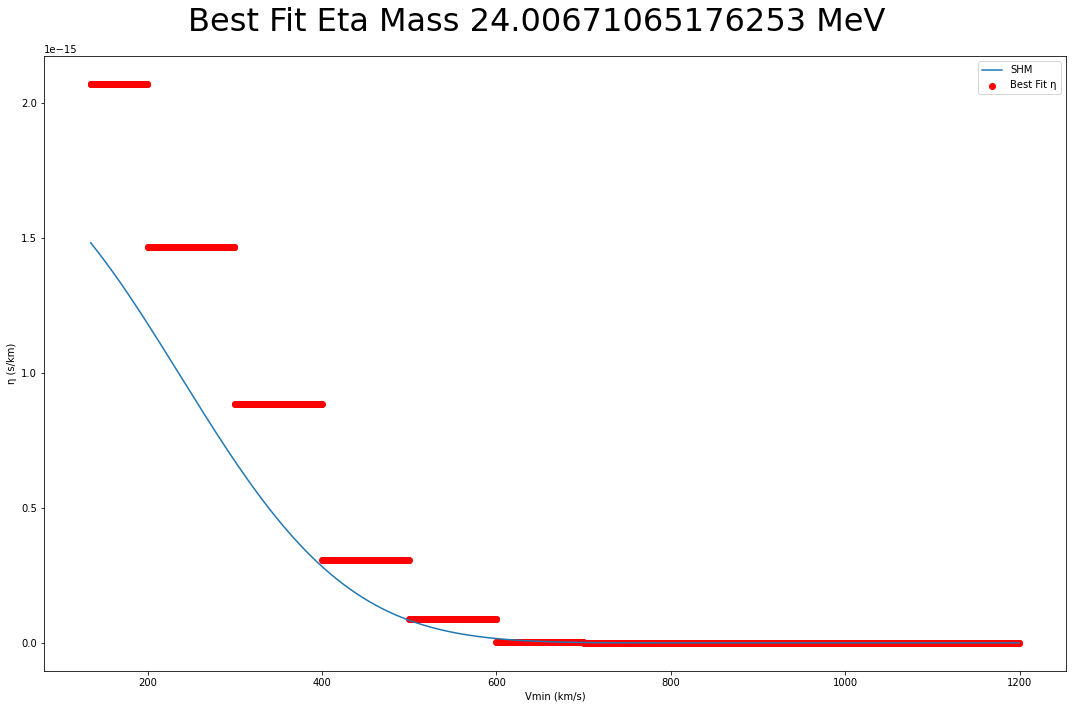

In [14]:

plot_eta(learnable_mass.detach().cpu().numpy()**2,convert_params_to_fit_to_halo_id(best_fit_params),plot_mb=True,device=best_fit_params.device,save=False,cross_section=1e-37,halo_params=tien_halo_params,norm=1e-15)
